# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.0005               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:

class ReplayBuffer():
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """
        Add new experience to memory 
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """
        Randomly sample a batch from memory 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device) 
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [11]:

class Agent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size 
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network 
        self.qnetwork_local = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.qnetwork_taget = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        
        # Initilize time steps (for updating UPDATE_EVERY)
        self.t_step = 0 
        
    def step(self, state, action, reward, next_state, done):
        # Save the experience 
        self.memory.add(state, action, reward, next_state, done)
        
        # Update counter 
        self.t_step += 1 
        
        # Update every UPDATE_EVERY (and if there are enough samples available then train on a sample)
        if self.t_step % UPDATE_EVERY == 0 and len(self.memory) >= BATCH_SIZE:
            expereinces = self.memory.sample() 
            self.learn(expereinces, GAMMA)
    
    def act(self, state, eps=0.):
        """
        Return action for a given state given the current policy 
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() 
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train() 
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size)) 
        
    def learn(self, expereinces, gamma):
        """
        Update value parameters using given batch of experience tuples
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = expereinces
        
        # Get max predicted Q values (for next_states) from qnetwork_target 
        Q_targets_next = self.qnetwork_taget(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q values for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from qnetwork_local 
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss 
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimise loss 
        self.optimizer.zero_grad() 
        loss.backward() 
        self.optimizer.step() 
        
        # Update target network 
        self.soft_update(self.qnetwork_local, self.qnetwork_taget, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data) 
            
    @staticmethod
    def create_agent(env, weights_file=None):
        # get the default brain
        brain_name = env.brain_names[0]
        brain = env.brains[brain_name]

        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]

        # number of actions
        action_size = brain.vector_action_space_size

        # get initial size 
        state = env_info.vector_observations[0]

        # number of states 
        state_size = len(state)

        print("Creating agent :: brain {}, action size {}, state size {}".format(brain_name, action_size, state_size))

        # Create our agent 
        agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    
        # load the weights from file
        if weights_file:
            agent.qnetwork_local.load_state_dict(torch.load(weights_file))
            
    
        return agent

In [12]:
import matplotlib.pyplot as plt
from scipy.interpolate import spline

%matplotlib inline

def plot_scores(scores):
    # plot the scores
    fig = plt.figure(figsize=(20, 10))
    
    x = np.arange(len(scores)) 
    y = scores         
        
    plt.plot(x, y)
    
    x_sm = np.array(x)
    y_sm = np.array(y)

    x_smooth = np.linspace(x_sm.min(), x_sm.max(), 30)
    y_smooth = spline(x, y, x_smooth)
    plt.plot(x_smooth, y_smooth, 'red', linewidth=4)
    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [13]:
from unityagents import UnityEnvironment

In [14]:
def train_agent(env, agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    print("Begining training with brain {}, number of episodes {}".format(brain_name, n_episodes))

    scores = [] # keep track of the scores 
    scores_window = deque(maxlen=100) # last 100 scores 
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):                    
            # select action 
            action = agent.act(state, eps) 
            # send the action to the environment
            env_info = env.step(action)[brain_name]        
            # get next state 
            next_state = env_info.vector_observations[0]
            # get reward 
            reward = env_info.rewards[0]
            # see if episode has finished 
            done = env_info.local_done[0]
            
            # update agent 
            agent.step(state, action, reward, next_state, done)            
            
            # Increment score 
            score += reward
            # update current state with next state 
            state = next_state 
            
            # Exit if done 
            if done:
                break 
                
        scores_window.append(score) # save most recent score
        scores.append(score) # save score                 
        eps = max(eps_end, eps * eps_decay) # decrease eps 
        
        if i_episode == 1 or i_episode % 100 == 0:
            print("Average score for episode {} is {:.2f}".format(i_episode, np.mean(scores_window)))
            # save network weights 
            torch.save(agent.qnetwork_local.state_dict(), 'navigation_agent_checkpoint.pth')            
    
    # save network weights 
    torch.save(agent.qnetwork_local.state_dict(), 'navigation_agent_checkpoint.pth')            
    
    return scores

In [15]:
agent = Agent.create_agent(env)

Creating agent :: brain BananaBrain, action size 4, state size 37


In [16]:
scores = train_agent(env, agent)

Begining training with brain BananaBrain, number of episodes 1000
Average score for episode 1 is 0.00
Average score for episode 100 is 0.91
Average score for episode 200 is 3.83
Average score for episode 300 is 7.48
Average score for episode 400 is 10.14
Average score for episode 500 is 13.05
Average score for episode 600 is 14.51
Average score for episode 700 is 15.31
Average score for episode 800 is 15.28
Average score for episode 900 is 15.60
Average score for episode 1000 is 14.43


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


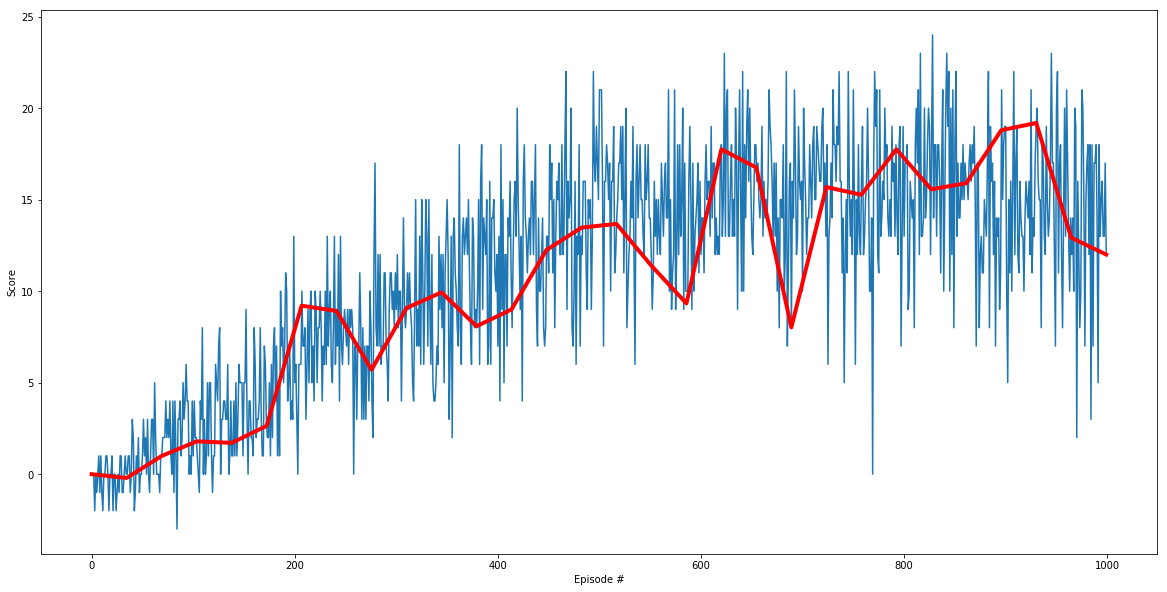

In [17]:
plot_scores(scores)

In [18]:
env.close()